In [370]:
import numpy as np
import pandas as pd

### data extraction from csv files

In [371]:
train_dataset = r"./match_history.csv"
df = pd.read_csv(train_dataset)
df

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,2021-12-07,Algeria,Egypt,Africa,Africa,32,45,1508,1449,1,...,No,Draw,78.0,NaN,78.0,81.0,78.0,NaN,79.3,70.8
5637,2021-12-08,Mexico,Chile,North America,South America,14,24,1638,1541,2,...,No,Draw,80.0,79.0,76.8,82.7,78.2,75.5,76.7,78.2
5638,2021-12-11,Morocco,Algeria,Africa,Africa,28,32,1525,1508,2,...,Yes,Lose,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0
5639,2021-12-18,Tunisia,Algeria,Africa,Africa,29,32,1512,1508,0,...,No,Lose,NaN,78.0,70.8,72.3,74.0,78.0,81.0,78.0


# Data preprocessing

### Team score data extraction (data extracted to dictionary scores)

In [372]:
train_dataset = r"./match_history.csv"
df = pd.read_csv(train_dataset)


#extract following columns
core_df = df[[
    "date", 
    "home_team", "away_team", 
    "home_team_fifa_rank", "away_team_fifa_rank",  
    'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
    'home_team_mean_defense_score', 'home_team_mean_offense_score',
    'home_team_mean_midfield_score', 'away_team_mean_defense_score',
    'away_team_mean_offense_score', 'away_team_mean_midfield_score',
    'home_team_result',
    ]].copy()

#simple data modification
core_df = core_df.fillna(0)
core_df["home_team_result"] = core_df["home_team_result"].replace(['Lose', 'Draw', 'Win'], [0, 1, 2])
core_df['date'] = core_df['date'].str.replace(r"\D", "")


#variables 
home_score = [
    'home_team_goalkeeper_score', 
    'home_team_mean_defense_score', 
    'home_team_mean_offense_score',
    'home_team_mean_midfield_score',
]

away_score = [
    'away_team_goalkeeper_score',
    'away_team_mean_defense_score',
    'away_team_mean_offense_score', 
    'away_team_mean_midfield_score',
]

#country = np.unique(country_name, return_counts=True)
country_list = df['home_team'].values
country_list = np.unique(country_list)

pos_score = [
    'gk_score',
    'def_score',
    'mid_score',
    'atk_score'
    ]


C:\Users\Sagat\AppData\Local\Temp\ipykernel_6800\3164666810.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  core_df['date'] = core_df['date'].str.replace(r"\D", "")


### Score data in dictionary scores

In [373]:
scores = {}


for index, row in core_df.iterrows():
    home = row['home_team']
    away = row['away_team']
    
    if home not in scores:
        scores[home] = {}
        scores[home]['gk_score'] = []
        scores[home]['def_score'] = []
        scores[home]['mid_score'] = []
        scores[home]['atk_score'] = []
        
    if away not in scores:
        scores[away] = {}
        scores[away]['gk_score'] = []
        scores[away]['def_score'] = []
        scores[away]['mid_score'] = []
        scores[away]['atk_score'] = []
    
    scores[home]['gk_score'].append([row['date'], row['home_team_goalkeeper_score']])
    scores[home]['def_score'].append([row['date'], row['home_team_mean_defense_score']])
    scores[home]['mid_score'].append([row['date'], row['home_team_mean_midfield_score']])
    scores[home]['atk_score'].append([row['date'],row['home_team_mean_offense_score']])
    
    scores[away]['gk_score'].append([row['date'], row['away_team_goalkeeper_score']])
    scores[away]['def_score'].append([row['date'], row['away_team_mean_defense_score']])
    scores[away]['mid_score'].append([row['date'], row['away_team_mean_midfield_score']])
    scores[away]['atk_score'].append([row['date'],row['away_team_mean_offense_score']])
    

### Feature Engineering

### Score data preprocessing

In [374]:
# fetch according country, position_team_mean_score from dict scores 
# if 0 not included in the data, returns an empty list => no missing values, no prediction needed
def fetch_country_pos_score(country, pos_score):
    predict_target = []
    model_data = []
    
    for item in scores[country][pos_score]:
        if 0 in item:
            predict_target.append(item)
        else:
            model_data.append(item)
            
    if predict_target == []:
        #print("No missing values")
        return []
            
    else:
        #if model_data == []:
            #print("No data available")
        #else:
            #print("Missing", len(predict_target), "values")   
        
        data = [model_data, predict_target]

        # model_data and predict_target to np float array
        data[0] = np.array(data[0]).astype(float)
        data[1] = np.array(data[1]).astype(float)

        return data

fetch_country_pos_score('Albania','gk_score')


[array([[2.0070912e+07, 5.2000000e+01],
        [2.0071013e+07, 5.2000000e+01],
        [2.0071017e+07, 5.2000000e+01],
        [2.0071121e+07, 5.2000000e+01],
        [2.0080527e+07, 5.2000000e+01],
        [2.0080906e+07, 5.1000000e+01],
        [2.0081011e+07, 5.1000000e+01],
        [2.0081015e+07, 5.1000000e+01],
        [2.0090328e+07, 5.1000000e+01],
        [2.0090401e+07, 5.1000000e+01],
        [2.0090606e+07, 5.1000000e+01],
        [2.0090610e+07, 5.1000000e+01],
        [2.0090909e+07, 6.5000000e+01],
        [2.0091014e+07, 6.5000000e+01],
        [2.0091114e+07, 6.5000000e+01],
        [2.0100303e+07, 6.5000000e+01],
        [2.0100525e+07, 6.5000000e+01],
        [2.0100903e+07, 6.9000000e+01],
        [2.0101008e+07, 6.9000000e+01],
        [2.0101012e+07, 6.9000000e+01],
        [2.0101117e+07, 6.9000000e+01],
        [2.0110209e+07, 6.9000000e+01],
        [2.0110326e+07, 6.9000000e+01],
        [2.0110607e+07, 6.9000000e+01],
        [2.0110620e+07, 6.9000000e+01],


In [375]:
def fetch_country_score(country):
    data = []
    
    #index 0: gk, index 1: def, index 2: mid, index 3: atk
    for score in pos_score:
        #print(score,": ",end = "")
        data.append(fetch_country_pos_score(country,score))
    
    return data

fetch_country_score('Albania')

[[array([[2.0070912e+07, 5.2000000e+01],
         [2.0071013e+07, 5.2000000e+01],
         [2.0071017e+07, 5.2000000e+01],
         [2.0071121e+07, 5.2000000e+01],
         [2.0080527e+07, 5.2000000e+01],
         [2.0080906e+07, 5.1000000e+01],
         [2.0081011e+07, 5.1000000e+01],
         [2.0081015e+07, 5.1000000e+01],
         [2.0090328e+07, 5.1000000e+01],
         [2.0090401e+07, 5.1000000e+01],
         [2.0090606e+07, 5.1000000e+01],
         [2.0090610e+07, 5.1000000e+01],
         [2.0090909e+07, 6.5000000e+01],
         [2.0091014e+07, 6.5000000e+01],
         [2.0091114e+07, 6.5000000e+01],
         [2.0100303e+07, 6.5000000e+01],
         [2.0100525e+07, 6.5000000e+01],
         [2.0100903e+07, 6.9000000e+01],
         [2.0101008e+07, 6.9000000e+01],
         [2.0101012e+07, 6.9000000e+01],
         [2.0101117e+07, 6.9000000e+01],
         [2.0110209e+07, 6.9000000e+01],
         [2.0110326e+07, 6.9000000e+01],
         [2.0110607e+07, 6.9000000e+01],
         [2.0110

### Show data

In [376]:
import matplotlib.pyplot as plt

# plot data based on country and pos_score info
def show_model_data(country, pos_score):
    data = fetch_country_pos_score(country, pos_score)
    
    # don't draw graph if there is no data to draw
    if data == [] or len(data[0]) == 0:
        return
    else:
        model_data = data[0]
        d = np.hsplit(model_data,2)
        plt.scatter(d[0],d[1])
        plt.xlabel('time')
        plt.ylabel(pos_score)
        plt.title("{} {}".format(country,pos_score))
        plt.show()

#show_model_data('Congo','mid_score')
show_model_data('Azerbaijan', 'def_score')

In [377]:
import matplotlib.pyplot as plt


# displays the variables that needs to be investigated to generate missing values
# so for Albania case, gk and def scores contain missing values => target for prediction
def show_model_data(country):
    print("-------------------------------")
    print(country, "Position Scores")
    print("-------------------------------")

    count = 0
    data = fetch_country_score(country)
    
    for elem in data:
        count += 1
        # again, don't display graph if there is no data
        if elem == [] or len(elem[0]) == 0:
            pass
        else:
            model_data = elem[0]
            d = np.hsplit(model_data,2)
            plt.scatter(d[0],d[1])
            plt.xlabel('time')
            if count == 1:
                plt.title("{} {}".format(country,'gk_score'))
                plt.ylabel('gk_score')
            elif count == 2:
                plt.title("{} {}".format(country,'def_score'))
                plt.ylabel('def_score')
            elif count == 3:
                plt.title("{} {}".format(country,'mid_score'))
                plt.ylabel('mid_score')
            else:
                plt.title("{} {}".format(country,'atk_score'))
                plt.ylabel('atk_score')
            plt.show()

#show_model_data('Albania')
show_model_data('Azerbaijan')

-------------------------------
Azerbaijan Position Scores
-------------------------------


In [378]:
# display all prediction targets
'''
for country in country_list:
    show_model_data(country)
    print("\n")
'''

'\nfor country in country_list:\n    show_model_data(country)\n    print("\n")\n'

In [379]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def lr_model(model_data):
    d = np.hsplit(model_data,2)
    date = d[0]
    pos = d[1]
    
    train_input, test_input, train_target, test_target = train_test_split(
    date, pos, random_state=42)
    
    lr = LinearRegression()

    lr.fit(train_input, train_target)
    print("Score: {}".format(lr.score(test_input, test_target)))
    
    return lr
    
data = fetch_country_pos_score('Albania', 'gk_score')
lr_model(data[0])

Score: 0.7899949532841467


LinearRegression()

### Gaussian Distribution

### Generate Data with Gaussian

In [380]:
import scipy.stats as stats
from statistics import mean
from scipy.stats import truncnorm

#translates from sample to sd space given a distribution's mean and sd
def sample_to_sd(sample, mean, sd):
    return (sample - mean) / sd

# use truncated gaussian bounded at lower and upper limits
def generate_truncated_gaussian(params):
    mean = params[0]
    sd = params[1]
    lower = params[2]
    upper = params[3]

    return truncnorm(sample_to_sd(lower, mean, sd), sample_to_sd(upper, mean, sd), loc= mean, scale = sd)

def get_gaussian_parameters(data):
    # average data for each score
    avg = np.mean(data[0], axis=0)[1]
    #avdef = np.mean(fetch_country_pos_score('Albania','def_score')[0], axis=0)[1]

    # variance data for each scores for Albania
    var= np.var(data[0], axis=0)[1]
    sd = np.sqrt(var)
    #vardef= np.var(fetch_country_pos_score('Albania','def_score')[0], axis=0)[1]

    #min and max to truncate gaussian
    min = np.amin(data[0], axis=0)[1]
    max = np.amax(data[0], axis=0)[1]

    return [avg, sd, min, max]

def sample_truncated_gaussian(data):
    params = get_gaussian_parameters(data)
    dist = generate_truncated_gaussian(params)

    if isinstance(dist, int):
        return dist

    return dist.rvs(1)[0]

In [381]:
def fetch_gaussian_pos_score(country, pos_score):
    data = fetch_country_pos_score(country, pos_score)
    #in this case there is no data at all for the position score
    if len(data[0]) == 0:
        return 50.0

    #subroutine to check if all data values are the same (invalid variance)
    sum = 0
    ln = len(data[0])
    for i in range(ln):
        sum += data[0][i][1]
    if sum/ln == data[0][0][1]:
        return data[0][0][1]


    return sample_truncated_gaussian(data)

fetch_gaussian_pos_score('Honduras', 'gk_score')

61.0

-------------------------------
Congo Position Scores
-------------------------------


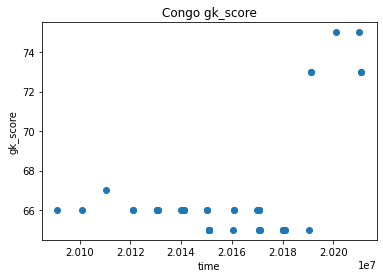

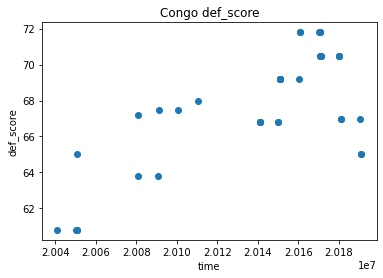

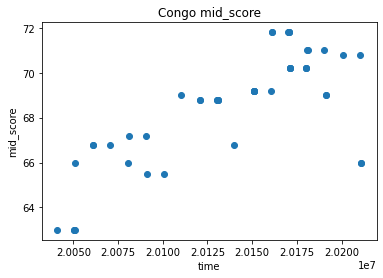

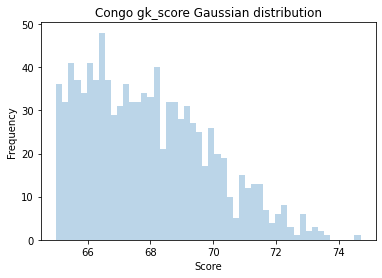

true mean =  66.68888888888888
standard deviation =  2.8033489672352188
min =  65.0
max =  75.0


In [382]:
show_model_data('Congo')

# gaussian distribution for country, pos_score
def show_gaussian_pos_score(country, pos_score):
    data = fetch_country_pos_score(country, pos_score)
    params = get_gaussian_parameters(data)

    X = generate_truncated_gaussian(params)
    plt.hist(X.rvs(1000), bins= 50, alpha=0.3)
    plt.title("{} {} Gaussian distribution".format(country, pos_score))
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

    print("true mean = ", params[0])
    print("standard deviation = ", params[1])
    print("min = ", params[2])
    print("max = ", params[3])


show_gaussian_pos_score('Congo', 'gk_score')

In [383]:
def fill_record_pos_scores(record):
    #countries in this record
    home = record['home_team']
    away = record['away_team']

    features = [
    'home_team_goalkeeper_score',
    'away_team_goalkeeper_score',
    'home_team_mean_defense_score',
    'away_team_mean_defense_score',
    'home_team_mean_offense_score',
    'away_team_mean_offense_score',
    'home_team_mean_midfield_score',
    'away_team_mean_midfield_score',
    ]

    #dictionary to check if a value corresponds to home or away team, and give the position
    check = {
    'home_team_goalkeeper_score':[1, 'gk_score'],
    'away_team_goalkeeper_score':[0, 'gk_score'],
    'home_team_mean_defense_score':[1, 'def_score'],
    'away_team_mean_defense_score':[0, 'def_score'],
    'home_team_mean_offense_score':[1, 'atk_score'],
    'away_team_mean_offense_score':[0, 'atk_score'],
    'home_team_mean_midfield_score':[1, 'mid_score'],
    'away_team_mean_midfield_score':[0, 'mid_score']
    }

    for feature in features:
        if record[feature] == 0:
            country = home
            if check[feature][0] == 0: 
                country = away
            position = check[feature][1]

            val = fetch_gaussian_pos_score(country, position)
            record[feature] = val
            #print(country, position, ":", val)

def fill_df_pos_scores(df):
    for index, record in df.iterrows():
        fill_record_pos_scores(record)

#fill_df_pos_scores(core_df)

### Comparing Results

In [400]:
from sklearn.linear_model import LogisticRegression
from collections import Counter

def logistic_regression_model(X, y):
    X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y)

    lr_model = LogisticRegression(random_state=0, max_iter=500).fit(X_train_lr, y_train_lr)
    lr_predictions = lr_model.predict(X_test_lr)

    return np.mean(lr_predictions == y_test_lr.values)*100

In [401]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def svm_model(X, y):
    X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y)
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='poly')).fit(X_train_svm, y_train_svm)
    svm_predictions = svm_model.predict(X_test_svm)

    return np.mean(svm_predictions == y_test_svm.values)*100

In [402]:
def test_model(func, num, X, y):
    sum = 0
    for i in range(num):
        sum += func(X, y)
    return sum/num

In [405]:
X1 = core_df[[
       'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'
]].copy()

y = core_df["home_team_result"]

base_lr = test_model(logistic_regression_model, 3, X1, y)
base_svm = test_model(svm_model, 3, X1, y)

#now getting data filled with the gaussian distribution
X2 = core_df[[
       "home_team", "away_team",
       'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'
]].copy()
fill_df_pos_scores(X2)
del X2['home_team']
del X2['away_team']

filled_lr = test_model(logistic_regression_model, 3, X2, y)
filled_svm = test_model(svm_model, 3, X2, y)

print("Base LR:", base_lr)
print("Base SVM:", base_svm)
print("\n")
print("Filled LR:", filled_lr)
print("Filled_SVM:", filled_svm)

Base LR: 53.720765414599576
Base SVM: 49.751948972360026


Filled LR: 53.39003071107961
Filled_SVM: 49.822820694542884
